# Прогностическая модель рисков беременных

Описание данных:
- `Age`: возраст беременной женщины в годах.
- `SystolicBP`: верхнее значение артериального давления в мм рт.ст.
- `DiastolicBP`: нижнее значение артериального давления в мм рт.ст.
- `BS`: Уровень глюкозы в крови определяется в виде молярной концентрации, ммоль/л.
- `BodyTemp`: Температура тела в градусах по Фаренгейту
- `HeartRate`: Нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.
- `RiskLevel`: Прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущих признаков.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression #, Ridge
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score #, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder #, LabelEncoder, OneHotEncoder
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline #, make_pipeline
from sklearn.compose import ColumnTransformer #, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
try:
    df = pd.read_csv('Maternal Health Risk Data Set.csv')
except:
    df = pd.read_csv('C:/Users/Anna/Downloads/Maternal Health Risk Data Set.csv')

In [3]:
def dfinfo(df):
    df.info()
    display(df.head())
    print('Пропуски:')
    print(df.isna().sum())
    print('Дубликатов', df.duplicated().sum())

dfinfo(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


Пропуски:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
Дубликатов 562


У нас 1014 строки в датасете, все признаки, кроме целевого, числовые. Пропусков нет, есть 562 дубликата. Но это, скорее всего, разные люди одного возраста с одинаковыми показателями. Если бы у нас было поле ФИО, это вряд ли были бы дубликаты.

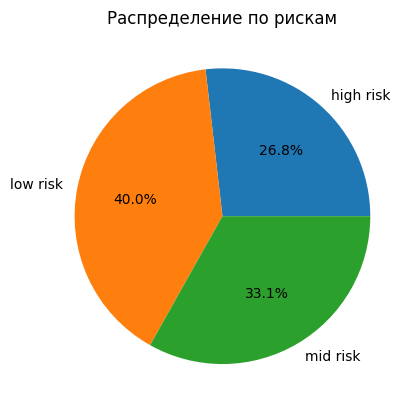

In [4]:
df.pivot_table(index='RiskLevel', aggfunc='count').plot(kind='pie', y='Age', autopct='%1.1f%%', ylabel='', legend=False, title='Распределение по рискам');

Чем ниже степень риска, тем больше доля выборки. Разница в размере групп по степени риска небольшая, дисбаланса классов нет.

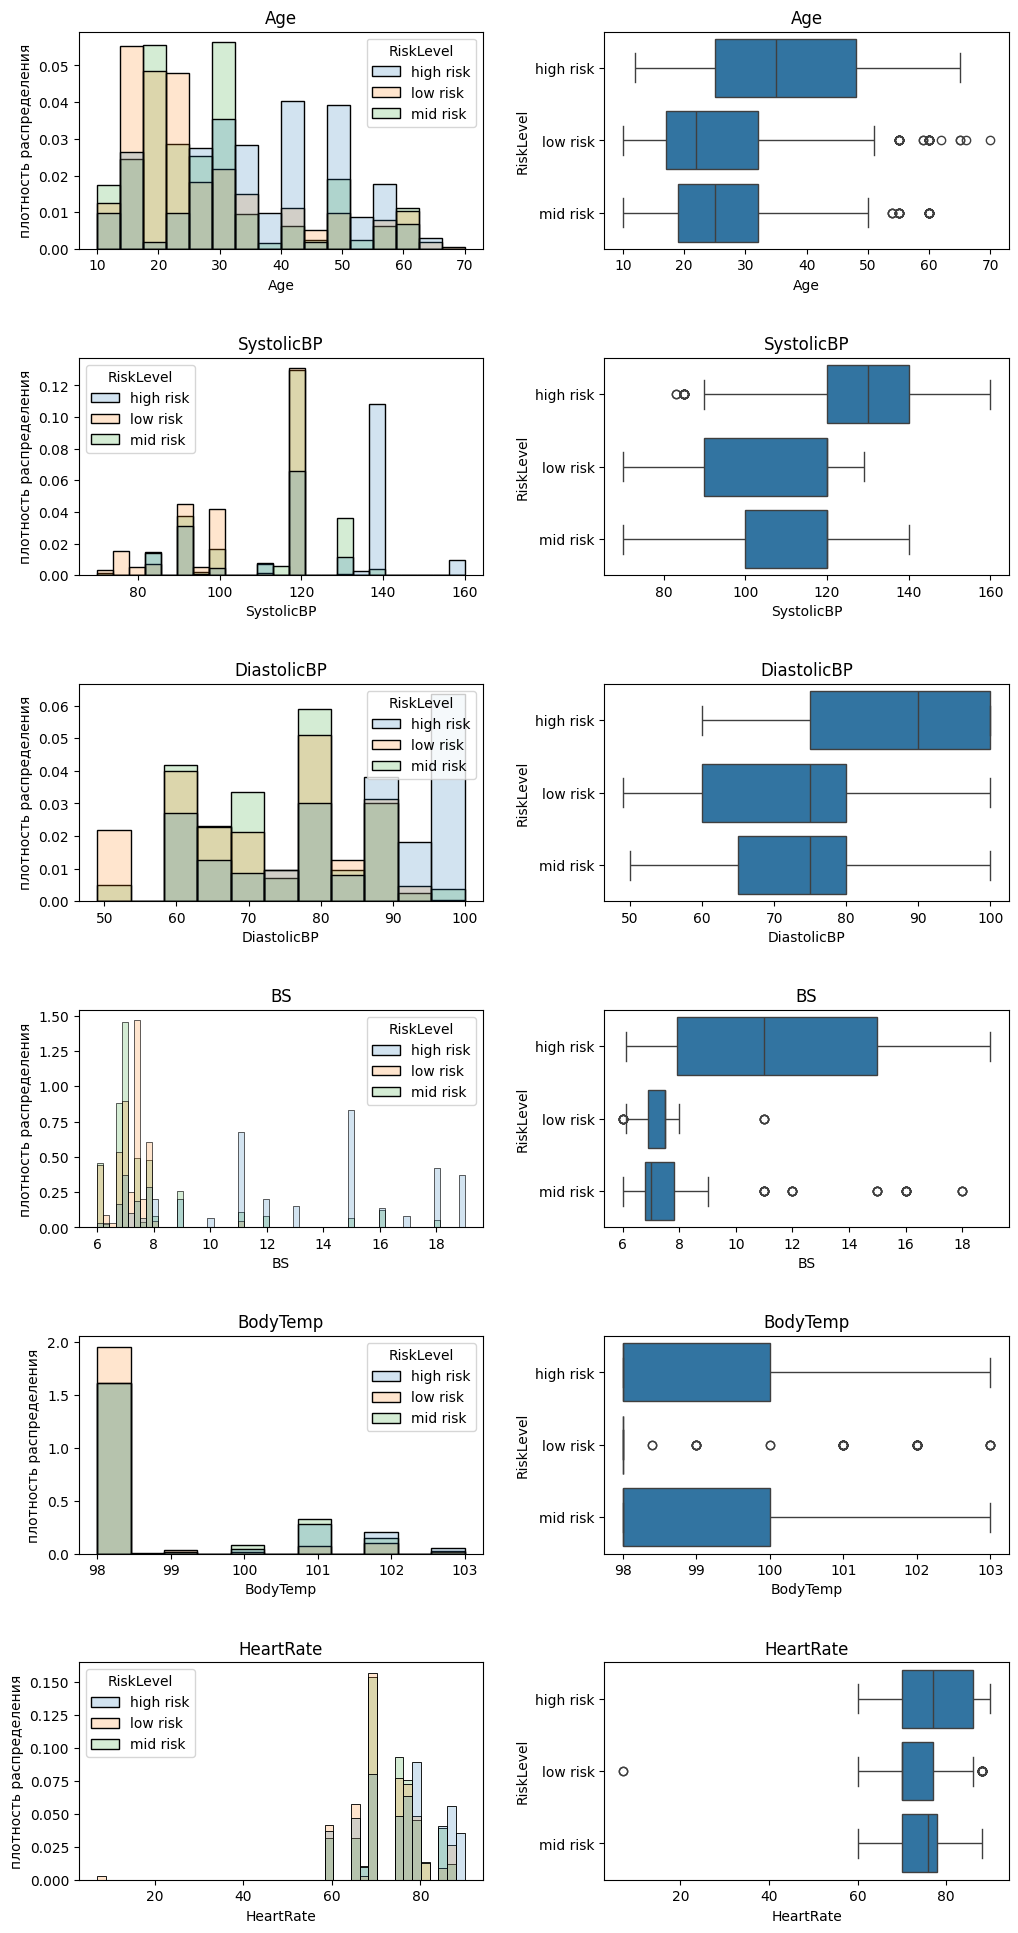

In [5]:
def eda_num(df):
  list_col = df.select_dtypes(exclude='object').columns
  fig,axes = plt.subplots(nrows=len(list_col), ncols=2, figsize=(12, len(list_col)*4), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
  i=0
  for col in list_col:
    sns.histplot(stat='density', common_norm=False, data=df, x=col, hue='RiskLevel', ax=axes[i][0], alpha=0.2).set(title=col, ylabel='плотность распределения')
    sns.boxplot(x=col, y='RiskLevel', data=df, ax=axes[i][1]).set(title=col)
    i+=1
  plt.show()

eda_num(df)

Посмотрим распределения мед. показателей по группам риска:
- Возраст от 10 до 70 (чудеса медицины) лет, причём малолетних так много, что это даже не выбросы.
- Верхнее давление 70-160, нижнее 47-100.
- Глюкоза 6-20 (у большинства 6-8, для низкого и среднего риска выше 8 выброс, для высокого обычные значения).
- Тепмература от 98 (нормальная по Фаренгейту, такая у большинства) до 103 (39,4 по Цельсию).
- Частота сердечных сокращений 55-90, кроме странного маленького значения у низкого риска:

In [6]:
df[df['HeartRate']<40]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


Всего 2 женщины с ЧСС = 7, причём низкий риск - явный выброс, удаляем это:

In [7]:
df = df[df['HeartRate']>40]

Делим на тренировочную и тестовую выборки (целевой признак - уровень риска, 3 группы, задача мультиклассовой классификации). В пайплайне выберем модель с лучшей метрикой accuracy (из логистической регрессии, KNN и дерева решений, с перебором гиперпараметров).

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df.drop(['RiskLevel'], axis=1)
#y = OrdinalEncoder(categories=[['low risk', 'mid risk', 'high risk']]).fit_transform(df[['RiskLevel']])
y = df['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify=y)

In [9]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), df.select_dtypes(exclude='object').columns)
    ],
    remainder='passthrough') # verbose_feature_names_out=False)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

param_grid = [
    # словарь для модели LogisticRegression())
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 20, 40, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
        # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [10]:
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object'))])),
                ('models',
                 DecisionTreeClassifier(max_depth=16, max_features=3,
                                        random_state=42))])


Метрика accuracy на кросс-валидации: 0.8301
Матрица ошибок на тренировочной выборке


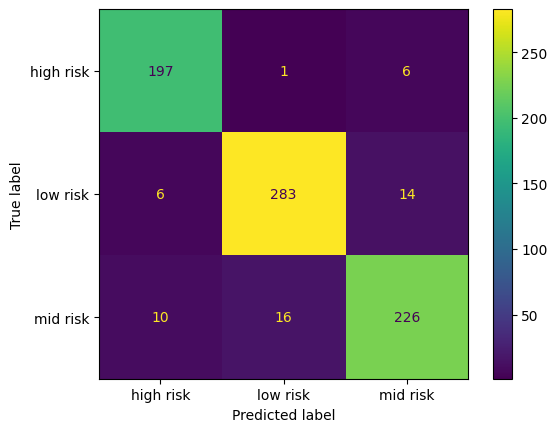

In [11]:
print('Метрика accuracy на кросс-валидации:', round(grid.best_score_, 4))
print('Матрица ошибок на тренировочной выборке')
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_train, y_train);

Метрика accuracy на тестовой выборке: 0.8458
Матрица ошибок на тестовой выборке


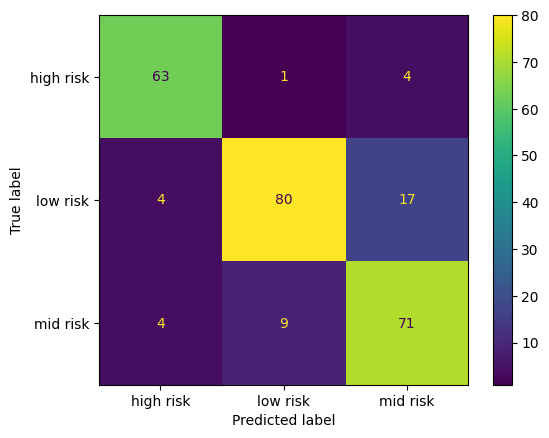

In [12]:
y_pred = grid.best_estimator_.predict(X_test)
#y_proba = grid.best_estimator_.predict_proba(X_test)
print('Метрика accuracy на тестовой выборке:', round(accuracy_score(y_test, y_pred), 4))
print('Матрица ошибок на тестовой выборке')
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test);

**Вывод:** самое критичное - правильно предсказать высокий риск, т.е. в матрице ошибок клетки, где по факту риск высокий, а предсказан низкий или средний, должны показывать как можно меньше, в идеале 0. У нас по 1 разу на трейне и на тесте модель предсказала низкий риск вместо высокого (2 женщины из 1012); средний вместо высокого 6 на трейне и 4 на тесте (10 из 1012). Заменой метрики (например, на ROC-AUC) добиться ещё снижения неверных предсказаний высокого риска не удалось. Лучшая модель - дерево решений.